# Introduction
Top 100 songs of the year 2006 - 2020

## Project description

Here is supposed to be project description

## Importing libraries

In [379]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import wget
import glob
import os
from twython import Twython
from credentials import * 
import requests
import json
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
%matplotlib inline
import regex as re

# Downloading data and scraping HTML websites 
Downloading HTML webpages with top 100 songs by year from www.billboard.com
- url - https://www.billboard.com/charts/year-end/hot-100-songs

## Downloading data

Here download data

## Scraping
- Scrape data from downloaded webpages and transform it into a `dataframe`

In [2]:
def get_webpage_data(start_year, end_year):
    
    df_full = pd.DataFrame()
    
    for i in range(start_year,end_year+1):
        year = i
    
        year = str(year)

        web_page = BeautifulSoup(open('../Top-songs-2006-2020/HTMLs/Top_100_'+year+'.html'), 'html.parser')

        all_titles = web_page.select('.ye-chart-item__title')
        all_artist = web_page.select('.ye-chart-item__artist')
        all_ranks = web_page.select('.ye-chart-item__rank')

        ranks_list = []
        for rank in all_ranks:
            ranks_list.append(rank.get_text().replace('\n', ''))

        titles_list = []
        for title in all_titles:
            titles_list.append(title.get_text().replace('\n', ''))

        artist_list = []
        for artist in all_artist:
            artist_list.append(artist.get_text().replace('\n', ''))

        year_list = []
        for year in web_page.select('.ye-chart-item__primary-row'):
            year_list.append(year['data-date'])

        df = pd.DataFrame(data = [ranks_list, titles_list, artist_list, year_list]).T
        df.columns = ['Rank', 'Title', 'Artist', 'Year']

        df_full = df_full.append(df)
        
    return df_full

In [3]:
full_df = get_webpage_data(2006,2020)
full_df.reset_index(drop = True, inplace = True)
full_df

,Rank,Title,Artist,Year
0,1,Bad Day,Daniel Powter,2006
1,2,Temperature,Sean Paul,2006
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006
3,4,You're Beautiful,James Blunt,2006
4,5,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006
...,...,...,...,...
1493,96,More Than My Hometown,Morgan Wallen,2020
1494,97,Lovin' On You,Luke Combs,2020
1495,98,Said Sum,Moneybagg Yo,2020
1496,99,Slide,H.E.R. Featuring YG,2020


# Spotify API

## Set up API

In [142]:
%run spotify_api_secret-Copy1.ipynb

In [161]:
auth_url = 'https://accounts.spotify.com/api/token'

auth_response = requests.post(auth_url, {
    'grant_type':'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})

auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']
headers = {'Authorization': 'Bearer {token}'.format(token = access_token)}

## Extracitng data from Spotify API

### Extracting track's ids, etc.

In [6]:
full_df.head(1)

,Rank,Title,Artist,Year
0,1,Bad Day,Daniel Powter,2006


In [7]:
track_names_spot = []
track_ids_spot = []
track_duration_spot = []
track_explicit_spot = []
track_popularity_spot = []
artist_name_spot = []

for track_name in full_df.Title:
    
    url = 'https://api.spotify.com/v1/search'

    track = requests.get(url, headers = headers, params = {'q':track_name, 'type':'track'}).json()
    
    track_names_spot.append(track['tracks']['items'][0]['name'])
    track_ids_spot.append(track['tracks']['items'][0]['id'])
    artist_name_spot.append(track['tracks']['items'][0]['album']['artists'][0]['name'])
    track_duration_spot.append(track['tracks']['items'][0]['duration_ms'])
    track_explicit_spot.append(track['tracks']['items'][0]['explicit'])
    track_popularity_spot.append(track['tracks']['items'][0]['popularity'])

In [8]:
df_spotify = pd.DataFrame(data = [track_names_spot, artist_name_spot, track_ids_spot, 
                    track_duration_spot, track_popularity_spot, track_explicit_spot]).T
df_spotify.columns = ['Title_spot', 'Artist_spot', 'Track_id', 'Track_duration_ms', 
                      'Track_popularity', 'Track_explicit']
df_spotify.head(3)

,Title_spot,Artist_spot,Track_id,Track_duration_ms,Track_popularity,Track_explicit
0,Bad Day - Single Version,Various Artists,64HJothMOwTKVWDzKxbZdR,145680,0,False
1,Temperature,Sean Paul,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False
2,Promiscuous,Nelly Furtado,2gam98EZKrF9XuOkU13ApN,242293,82,False


### Merging two DataFrames

In [9]:
df_spotify.head(3)

,Title_spot,Artist_spot,Track_id,Track_duration_ms,Track_popularity,Track_explicit
0,Bad Day - Single Version,Various Artists,64HJothMOwTKVWDzKxbZdR,145680,0,False
1,Temperature,Sean Paul,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False
2,Promiscuous,Nelly Furtado,2gam98EZKrF9XuOkU13ApN,242293,82,False


In [10]:
full_df.head(3)

,Rank,Title,Artist,Year
0,1,Bad Day,Daniel Powter,2006
1,2,Temperature,Sean Paul,2006
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006


In [11]:
df = full_df.merge(right = df_spotify, left_index = True, right_index = True)
df

,Rank,Title,Artist,Year,Title_spot,Artist_spot,Track_id,Track_duration_ms,Track_popularity,Track_explicit
0,1,Bad Day,Daniel Powter,2006,Bad Day - Single Version,Various Artists,64HJothMOwTKVWDzKxbZdR,145680,0,False
1,2,Temperature,Sean Paul,2006,Temperature,Sean Paul,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006,Promiscuous,Nelly Furtado,2gam98EZKrF9XuOkU13ApN,242293,82,False
3,4,You're Beautiful,James Blunt,2006,You're Beautiful,James Blunt,0vg4WnUWvze6pBOJDTq99k,209493,77,True
4,5,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006,Hips Don't Lie (feat. Wyclef Jean),Shakira,3ZFTkvIE7kyPt6Nu3PEa7V,218093,84,False
...,...,...,...,...,...,...,...,...,...,...
1493,96,More Than My Hometown,Morgan Wallen,2020,More Than My Hometown,Morgan Wallen,5OELUCYgOHKFAvCERnAvfS,216573,76,False
1494,97,Lovin' On You,Luke Combs,2020,Lovin' On You,Luke Combs,0nYvjcSlCgjcwogQAwIwNp,194866,72,False
1495,98,Said Sum,Moneybagg Yo,2020,Said Sum,Moneybagg Yo,3sKz6Sd72K0ofPWcJPPk6H,155168,72,True
1496,99,Slide,H.E.R. Featuring YG,2020,Slide,H.E.R.,2rTnVB1bvwxHtaIl4uVu7f,238321,73,True


### Extracting Audio Features of the tracks

In [12]:
requests_list = []

for track_id in df.Track_id:
    
    url = 'https://api.spotify.com/v1/audio-features/'+track_id
    
    requests_list.append(requests.get(url, headers = headers).json())

In [13]:
df_audio_feautures = pd.DataFrame()

i = 0

for i in range(len(requests_list)):
    
    temp_df = pd.DataFrame.from_dict(requests_list[i], orient = 'Index').T
    
    df_audio_feautures = df_audio_feautures.append(temp_df)
    
    i += 1

In [14]:
df_audio_feautures.reset_index(drop = True, inplace = True)
df_audio_feautures

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.676,0.509,11,-6.838,0,0.0423,0.0221,0,0.221,0.313,81.981,audio_features,64HJothMOwTKVWDzKxbZdR,spotify:track:64HJothMOwTKVWDzKxbZdR,https://api.spotify.com/v1/tracks/64HJothMOwTK...,https://api.spotify.com/v1/audio-analysis/64HJ...,145680,4
1,0.951,0.6,0,-4.675,0,0.0685,0.106,0,0.0712,0.822,125.04,audio_features,0k2GOhqsrxDTAbFFSdNJjT,spotify:track:0k2GOhqsrxDTAbFFSdNJjT,https://api.spotify.com/v1/tracks/0k2GOhqsrxDT...,https://api.spotify.com/v1/audio-analysis/0k2G...,218573,4
2,0.808,0.97,10,-6.098,0,0.0506,0.0569,0.000061,0.154,0.868,114.328,audio_features,2gam98EZKrF9XuOkU13ApN,spotify:track:2gam98EZKrF9XuOkU13ApN,https://api.spotify.com/v1/tracks/2gam98EZKrF9...,https://api.spotify.com/v1/audio-analysis/2gam...,242293,4
3,0.675,0.479,0,-9.87,0,0.0278,0.633,0.000018,0.088,0.454,81.998,audio_features,0vg4WnUWvze6pBOJDTq99k,spotify:track:0vg4WnUWvze6pBOJDTq99k,https://api.spotify.com/v1/tracks/0vg4WnUWvze6...,https://api.spotify.com/v1/audio-analysis/0vg4...,209493,4
4,0.778,0.824,10,-5.892,0,0.0707,0.284,0,0.405,0.758,100.024,audio_features,3ZFTkvIE7kyPt6Nu3PEa7V,spotify:track:3ZFTkvIE7kyPt6Nu3PEa7V,https://api.spotify.com/v1/tracks/3ZFTkvIE7kyP...,https://api.spotify.com/v1/audio-analysis/3ZFT...,218093,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.62,0.869,6,-5.479,1,0.0462,0.615,0,0.131,0.597,126.019,audio_features,5OELUCYgOHKFAvCERnAvfS,spotify:track:5OELUCYgOHKFAvCERnAvfS,https://api.spotify.com/v1/tracks/5OELUCYgOHKF...,https://api.spotify.com/v1/audio-analysis/5OEL...,216573,4
1494,0.572,0.949,4,-4.865,1,0.06,0.00165,0.000195,0.163,0.53,118.974,audio_features,0nYvjcSlCgjcwogQAwIwNp,spotify:track:0nYvjcSlCgjcwogQAwIwNp,https://api.spotify.com/v1/tracks/0nYvjcSlCgjc...,https://api.spotify.com/v1/audio-analysis/0nYv...,194867,4
1495,0.929,0.667,8,-6.789,0,0.353,0.0185,0,0.1,0.274,126.998,audio_features,3sKz6Sd72K0ofPWcJPPk6H,spotify:track:3sKz6Sd72K0ofPWcJPPk6H,https://api.spotify.com/v1/tracks/3sKz6Sd72K0o...,https://api.spotify.com/v1/audio-analysis/3sKz...,155168,4
1496,0.827,0.469,10,-9.141,0,0.341,0.0807,0.000008,0.207,0.196,97.028,audio_features,2rTnVB1bvwxHtaIl4uVu7f,spotify:track:2rTnVB1bvwxHtaIl4uVu7f,https://api.spotify.com/v1/tracks/2rTnVB1bvwxH...,https://api.spotify.com/v1/audio-analysis/2rTn...,238321,4


### Cleaning Spotify data frame

#### Dealing with extraction error (not needed if extraction limit not exceeded)

In [33]:
'''

len(df_audio_feautures)
df_audio_feautures.error.unique()[1:]
len(df_audio_feautures[df_audio_feautures.error == 'API rate limit exceeded'])
len(df_audio_feautures[df_audio_feautures.error == 'analysis not found'])
len(df_audio_feautures[df_audio_feautures.error == '429'])
len(df_audio_feautures[df_audio_feautures.error == '404'])
df_audio_feautures.drop(df_audio_feautures[df_audio_feautures.error == 'API rate limit exceeded'].index, 
                    inplace = True)

df_audio_feautures.drop(df_audio_feautures[df_audio_feautures.error == 'analysis not found'].index, 
                    inplace = True)

len(df_audio_feautures)

'''

"\n\nlen(df_audio_feautures)\ndf_audio_feautures.error.unique()[1:]\nlen(df_audio_feautures[df_audio_feautures.error == 'API rate limit exceeded'])\nlen(df_audio_feautures[df_audio_feautures.error == 'analysis not found'])\nlen(df_audio_feautures[df_audio_feautures.error == '429'])\nlen(df_audio_feautures[df_audio_feautures.error == '404'])\ndf_audio_feautures.drop(df_audio_feautures[df_audio_feautures.error == 'API rate limit exceeded'].index, \n                    inplace = True)\n\ndf_audio_feautures.drop(df_audio_feautures[df_audio_feautures.error == 'analysis not found'].index, \n                    inplace = True)\n\nlen(df_audio_feautures)\n\n"

# Merge dataframes to the final dataframe

In [18]:
df_audio_feautures.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.676,0.509,11,-6.838,0,0.0423,0.0221,0,0.221,0.313,81.981,audio_features,64HJothMOwTKVWDzKxbZdR,spotify:track:64HJothMOwTKVWDzKxbZdR,https://api.spotify.com/v1/tracks/64HJothMOwTK...,https://api.spotify.com/v1/audio-analysis/64HJ...,145680,4
1,0.951,0.6,0,-4.675,0,0.0685,0.106,0,0.0712,0.822,125.04,audio_features,0k2GOhqsrxDTAbFFSdNJjT,spotify:track:0k2GOhqsrxDTAbFFSdNJjT,https://api.spotify.com/v1/tracks/0k2GOhqsrxDT...,https://api.spotify.com/v1/audio-analysis/0k2G...,218573,4
2,0.808,0.97,10,-6.098,0,0.0506,0.0569,0.000061,0.154,0.868,114.328,audio_features,2gam98EZKrF9XuOkU13ApN,spotify:track:2gam98EZKrF9XuOkU13ApN,https://api.spotify.com/v1/tracks/2gam98EZKrF9...,https://api.spotify.com/v1/audio-analysis/2gam...,242293,4
3,0.675,0.479,0,-9.87,0,0.0278,0.633,0.000018,0.088,0.454,81.998,audio_features,0vg4WnUWvze6pBOJDTq99k,spotify:track:0vg4WnUWvze6pBOJDTq99k,https://api.spotify.com/v1/tracks/0vg4WnUWvze6...,https://api.spotify.com/v1/audio-analysis/0vg4...,209493,4
4,0.778,0.824,10,-5.892,0,0.0707,0.284,0,0.405,0.758,100.024,audio_features,3ZFTkvIE7kyPt6Nu3PEa7V,spotify:track:3ZFTkvIE7kyPt6Nu3PEa7V,https://api.spotify.com/v1/tracks/3ZFTkvIE7kyP...,https://api.spotify.com/v1/audio-analysis/3ZFT...,218093,4


In [19]:
df.head()

,Rank,Title,Artist,Year,Title_spot,Artist_spot,Track_id,Track_duration_ms,Track_popularity,Track_explicit
0,1,Bad Day,Daniel Powter,2006,Bad Day - Single Version,Various Artists,64HJothMOwTKVWDzKxbZdR,145680,0,False
1,2,Temperature,Sean Paul,2006,Temperature,Sean Paul,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006,Promiscuous,Nelly Furtado,2gam98EZKrF9XuOkU13ApN,242293,82,False
3,4,You're Beautiful,James Blunt,2006,You're Beautiful,James Blunt,0vg4WnUWvze6pBOJDTq99k,209493,77,True
4,5,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006,Hips Don't Lie (feat. Wyclef Jean),Shakira,3ZFTkvIE7kyPt6Nu3PEa7V,218093,84,False


## Checking if both dataframe's indexes share the same track id

In [138]:
number = 1234

In [139]:
df_audio_feautures.iloc[number].id

'6Qn5zhYkTa37e91HC1D7lb'

In [140]:
df.iloc[number].Track_id

'6Qn5zhYkTa37e91HC1D7lb'

## Merging two dataframes

In [358]:
df_merged = df.merge(right = df_audio_feautures, left_index = True, right_index = True)

In [359]:
df_merged.head(3)

,Rank,Title,Artist,Year,Title_spot,Artist_spot,Track_id,Track_duration_ms,Track_popularity,Track_explicit,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,1,Bad Day,Daniel Powter,2006,Bad Day - Single Version,Various Artists,64HJothMOwTKVWDzKxbZdR,145680,0,False,...,0.221,0.313,81.981,audio_features,64HJothMOwTKVWDzKxbZdR,spotify:track:64HJothMOwTKVWDzKxbZdR,https://api.spotify.com/v1/tracks/64HJothMOwTK...,https://api.spotify.com/v1/audio-analysis/64HJ...,145680,4
1,2,Temperature,Sean Paul,2006,Temperature,Sean Paul,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False,...,0.0712,0.822,125.04,audio_features,0k2GOhqsrxDTAbFFSdNJjT,spotify:track:0k2GOhqsrxDTAbFFSdNJjT,https://api.spotify.com/v1/tracks/0k2GOhqsrxDT...,https://api.spotify.com/v1/audio-analysis/0k2G...,218573,4
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006,Promiscuous,Nelly Furtado,2gam98EZKrF9XuOkU13ApN,242293,82,False,...,0.154,0.868,114.328,audio_features,2gam98EZKrF9XuOkU13ApN,spotify:track:2gam98EZKrF9XuOkU13ApN,https://api.spotify.com/v1/tracks/2gam98EZKrF9...,https://api.spotify.com/v1/audio-analysis/2gam...,242293,4


## Cleaning df_tracks data frame

In [360]:
df_merged.columns

Index(['Rank', 'Title', 'Artist', 'Year', 'Title_spot', 'Artist_spot',
       'Track_id', 'Track_duration_ms', 'Track_popularity', 'Track_explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [361]:
df_merged.drop(columns = ['analysis_url', 'track_href', 'uri', 'id', 'mode', 
                          'Title_spot', 'Artist_spot', 'duration_ms', 'type'], inplace = True)

In [362]:
df_merged

,Rank,Title,Artist,Year,Track_id,Track_duration_ms,Track_popularity,Track_explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1,Bad Day,Daniel Powter,2006,64HJothMOwTKVWDzKxbZdR,145680,0,False,0.676,0.509,11,-6.838,0.0423,0.0221,0,0.221,0.313,81.981,4
1,2,Temperature,Sean Paul,2006,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False,0.951,0.6,0,-4.675,0.0685,0.106,0,0.0712,0.822,125.04,4
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006,2gam98EZKrF9XuOkU13ApN,242293,82,False,0.808,0.97,10,-6.098,0.0506,0.0569,0.000061,0.154,0.868,114.328,4
3,4,You're Beautiful,James Blunt,2006,0vg4WnUWvze6pBOJDTq99k,209493,77,True,0.675,0.479,0,-9.87,0.0278,0.633,0.000018,0.088,0.454,81.998,4
4,5,Hips Don't Lie,Shakira Featuring Wyclef Jean,2006,3ZFTkvIE7kyPt6Nu3PEa7V,218093,84,False,0.778,0.824,10,-5.892,0.0707,0.284,0,0.405,0.758,100.024,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,96,More Than My Hometown,Morgan Wallen,2020,5OELUCYgOHKFAvCERnAvfS,216573,76,False,0.62,0.869,6,-5.479,0.0462,0.615,0,0.131,0.597,126.019,4
1494,97,Lovin' On You,Luke Combs,2020,0nYvjcSlCgjcwogQAwIwNp,194866,72,False,0.572,0.949,4,-4.865,0.06,0.00165,0.000195,0.163,0.53,118.974,4
1495,98,Said Sum,Moneybagg Yo,2020,3sKz6Sd72K0ofPWcJPPk6H,155168,72,True,0.929,0.667,8,-6.789,0.353,0.0185,0,0.1,0.274,126.998,4
1496,99,Slide,H.E.R. Featuring YG,2020,2rTnVB1bvwxHtaIl4uVu7f,238321,73,True,0.827,0.469,10,-9.141,0.341,0.0807,0.000008,0.207,0.196,97.028,4


In [75]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rank               1498 non-null   object
 1   Title              1498 non-null   object
 2   Artist             1498 non-null   object
 3   Year               1498 non-null   object
 4   Track_id           1498 non-null   object
 5   Track_duration_ms  1498 non-null   object
 6   Track_popularity   1498 non-null   object
 7   Track_explicit     1498 non-null   object
 8   danceability       1498 non-null   object
 9   energy             1498 non-null   object
 10  key                1498 non-null   object
 11  loudness           1498 non-null   object
 12  speechiness        1498 non-null   object
 13  acousticness       1498 non-null   object
 14  instrumentalness   1498 non-null   object
 15  liveness           1498 non-null   object
 16  valence            1498 non-null   object


In [363]:
df_merged.Rank = pd.to_numeric(df_merged.Rank)


In [364]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rank               1498 non-null   int64 
 1   Title              1498 non-null   object
 2   Artist             1498 non-null   object
 3   Year               1498 non-null   object
 4   Track_id           1498 non-null   object
 5   Track_duration_ms  1498 non-null   object
 6   Track_popularity   1498 non-null   object
 7   Track_explicit     1498 non-null   object
 8   danceability       1498 non-null   object
 9   energy             1498 non-null   object
 10  key                1498 non-null   object
 11  loudness           1498 non-null   object
 12  speechiness        1498 non-null   object
 13  acousticness       1498 non-null   object
 14  instrumentalness   1498 non-null   object
 15  liveness           1498 non-null   object
 16  valence            1498 non-null   object


In [365]:
for col in ['Rank','Track_duration_ms','Track_popularity','danceability','energy', 'key', 'loudness', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
            'time_signature']:
    df_merged[col] = pd.to_numeric(df_merged[col],errors='coerce').fillna(0)

In [366]:
df_merged.Year = pd.to_datetime(df_merged.Year)

In [367]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Rank               1498 non-null   int64         
 1   Title              1498 non-null   object        
 2   Artist             1498 non-null   object        
 3   Year               1498 non-null   datetime64[ns]
 4   Track_id           1498 non-null   object        
 5   Track_duration_ms  1498 non-null   int64         
 6   Track_popularity   1498 non-null   int64         
 7   Track_explicit     1498 non-null   object        
 8   danceability       1498 non-null   float64       
 9   energy             1498 non-null   float64       
 10  key                1498 non-null   int64         
 11  loudness           1498 non-null   float64       
 12  speechiness        1498 non-null   float64       
 13  acousticness       1498 non-null   float64       
 14  instrume

In [368]:
df_merged.head(3)

,Rank,Title,Artist,Year,Track_id,Track_duration_ms,Track_popularity,Track_explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1,Bad Day,Daniel Powter,2006-01-01,64HJothMOwTKVWDzKxbZdR,145680,0,False,0.676,0.509,11,-6.838,0.0423,0.0221,0.000000,0.2210,0.313,81.981,4
1,2,Temperature,Sean Paul,2006-01-01,0k2GOhqsrxDTAbFFSdNJjT,218573,79,False,0.951,0.600,0,-4.675,0.0685,0.1060,0.000000,0.0712,0.822,125.040,4
2,3,Promiscuous,Nelly Furtado Featuring Timbaland,2006-01-01,2gam98EZKrF9XuOkU13ApN,242293,82,False,0.808,0.970,10,-6.098,0.0506,0.0569,0.000061,0.1540,0.868,114.328,4


# Exploratory Data Analysis (EDA)

## Audio Features Correlation

<AxesSubplot:>

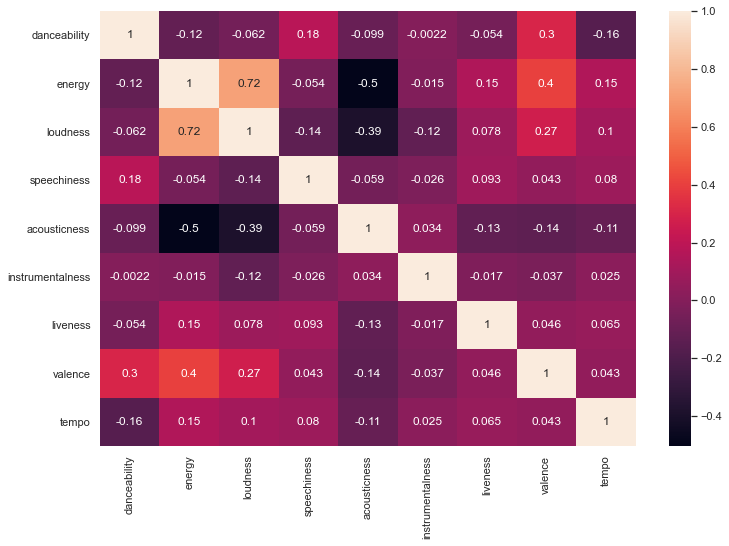

In [291]:
corr = df_merged[['danceability','energy','loudness', 'speechiness','acousticness',
'instrumentalness','liveness','valence', 'tempo']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)

- So it seems that Loudness and Energy are strognly correlated
- Acousticness and energy as well as acousticness and loudness have a moderate negative correlation

## Audio Features comparison by year

### Mean of top 100 tracks audio features by year

In [300]:
df_top100_mean = df_merged.groupby('Year').mean()[['Track_duration_ms', 'danceability', 'energy', 'loudness', 
                                  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                                 'tempo']]
df_top100_mean

,Track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Year,,,,,,,,,,
2006-01-01,232331.220000,0.670580,0.671200,-6.085450,0.131564,0.149270,0.001973,0.190809,0.540140,115.229080
2007-01-01,239842.150000,0.654200,0.703680,-5.781830,0.112062,0.159379,0.018163,0.184297,0.572060,121.213850
2008-01-01,232298.730000,0.650730,0.677144,-6.128200,0.082629,0.155399,0.012945,0.177912,0.531523,122.400860
2009-01-01,233663.410000,0.619090,0.699490,-5.497580,0.078350,0.153694,0.005451,0.189439,0.518510,128.372930
2010-01-01,226784.460000,0.635620,0.728230,-5.229230,0.089839,0.140885,0.012595,0.195429,0.537755,120.444930
2011-01-01,229825.404040,0.633232,0.739283,-5.295283,0.093645,0.131068,0.003013,0.193142,0.552844,123.924333
2012-01-01,221416.070000,0.663920,0.725830,-5.356490,0.084814,0.114378,0.002584,0.177398,0.559030,124.679890
2013-01-01,227251.030000,0.637210,0.679600,-5.852290,0.092207,0.155487,0.007624,0.163617,0.529643,121.278790
2014-01-01,226813.040000,0.661550,0.678240,-5.620510,0.086133,0.147912,0.002572,0.167022,0.524750,123.282840


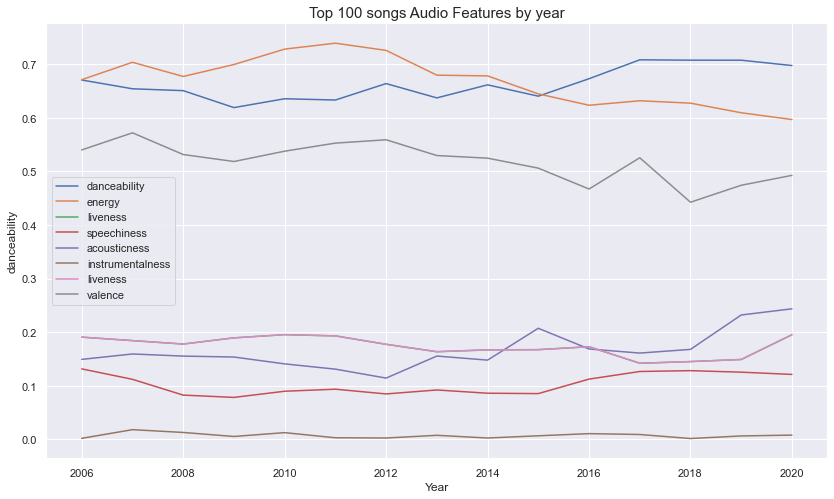

In [328]:
plt.figure(figsize = (14, 8))
plt.title("Top 100 songs Audio Features by year", fontsize = 15)
lines = ['danceability','energy','liveness','speechiness','acousticness',
         'instrumentalness','liveness','valence']
for line in lines:
    ax = sns.lineplot(x = df_top100_mean.index.year, y = line, data = df_top100_mean)
plt.legend(lines)

<AxesSubplot:xlabel='Year', ylabel='Track_duration_ms'>

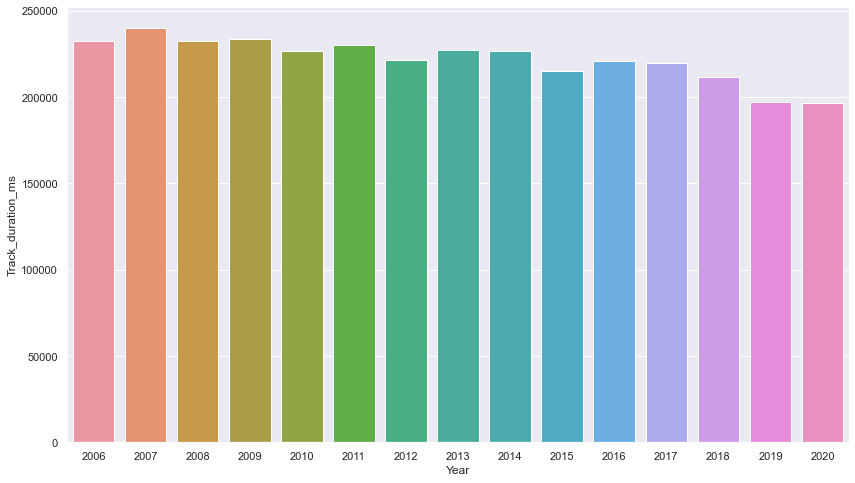

In [314]:
sns.set_theme(style="white", context="talk")
sns.set(rc={'figure.figsize':(14,8)})
plt.xticks(rotation=0)
sns.barplot(x = df_top100_mean.index.year, y = df_top100_mean.Track_duration_ms)

<AxesSubplot:xlabel='Year', ylabel='tempo'>

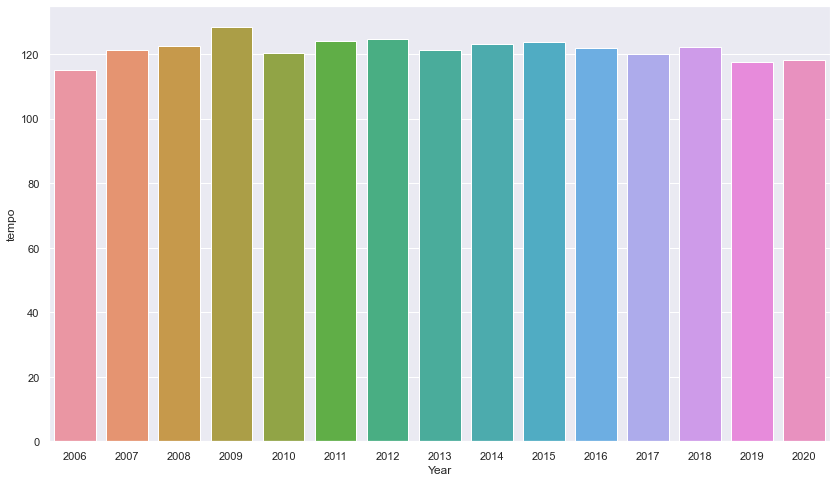

In [316]:
sns.barplot(x = df_top100_mean.index.year, y = df_top100_mean.tempo)

### Mean of top 20 tracks audio features by year

In [317]:
df_top20_mean = df_merged[df_merged.Rank.between(1,21)].groupby('Year').mean()[['Track_duration_ms', 'danceability', 'energy', 'loudness', 
                                  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                                 'tempo']]
df_top20_mean

,Track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Year,,,,,,,,,,
2006-01-01,226776.190476,0.704905,0.697952,-5.800667,0.107400,0.154714,0.000019,0.194052,0.656571,120.786190
2007-01-01,230016.428571,0.716095,0.715143,-5.510190,0.116581,0.204903,0.035861,0.155110,0.629810,126.632238
2008-01-01,232591.000000,0.652571,0.665762,-5.687476,0.069686,0.163367,0.000202,0.160690,0.496381,126.340571
2009-01-01,241891.095238,0.635048,0.720095,-5.463524,0.092914,0.077250,0.000117,0.193119,0.552333,135.690476
2010-01-01,244126.523810,0.691810,0.790333,-5.085952,0.113076,0.106642,0.043881,0.213929,0.579048,122.600905
2011-01-01,231976.650000,0.692350,0.763850,-5.091250,0.084550,0.095751,0.008567,0.217010,0.594400,121.714650
2012-01-01,225865.619048,0.679762,0.749476,-5.005667,0.077995,0.071860,0.001191,0.172814,0.602333,127.272762
2013-01-01,237021.857143,0.639286,0.622000,-6.154048,0.067981,0.194789,0.000164,0.175362,0.543476,111.987381
2014-01-01,211589.666667,0.675095,0.664762,-5.910381,0.089376,0.200110,0.006751,0.159890,0.573476,121.754619


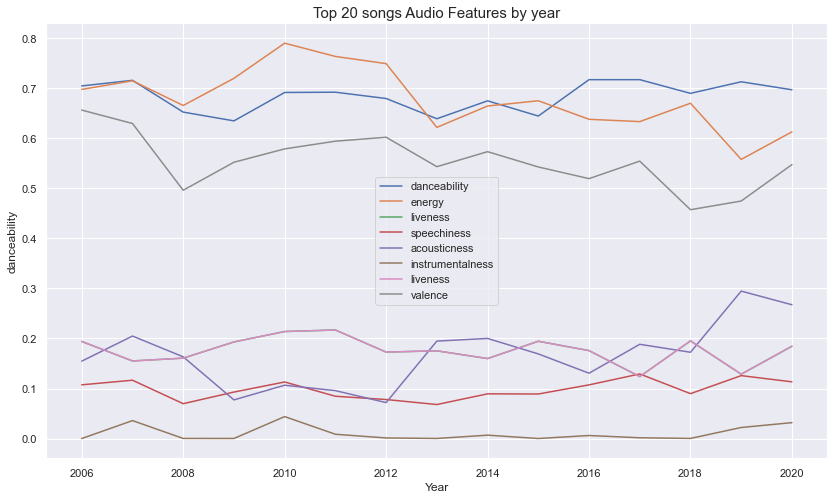

In [329]:
plt.figure(figsize = (14, 8))
plt.title("Top 20 songs Audio Features by year", fontsize = 15)
lines = ['danceability','energy','liveness','speechiness','acousticness',
         'instrumentalness','liveness','valence']
for line in lines:
    ax = sns.lineplot(x = df_top20_mean.index.year, y = line, data = df_top20_mean)
plt.legend(lines)

<AxesSubplot:xlabel='Year', ylabel='Track_duration_ms'>

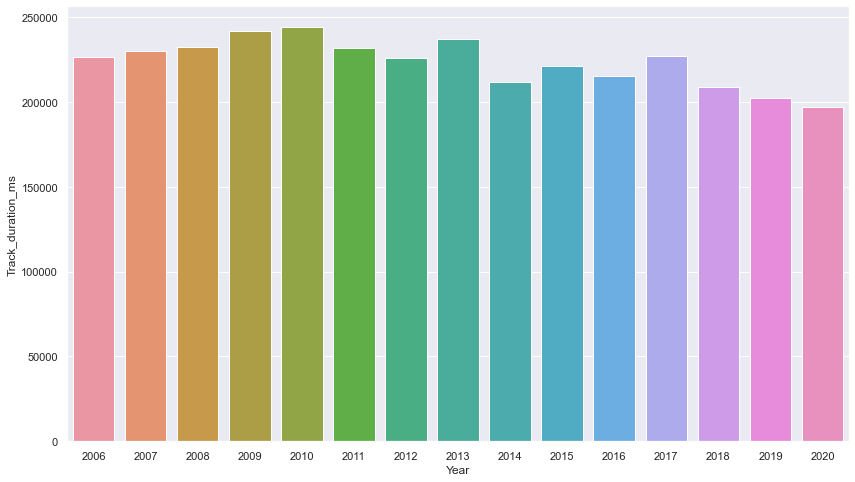

In [327]:
sns.set_theme(style="white", context="talk")
sns.set(rc={'figure.figsize':(14,8)})
plt.xticks(rotation=0)
sns.barplot(x = df_top20_mean.index.year, y = df_top20_mean.Track_duration_ms)

<AxesSubplot:xlabel='Year', ylabel='tempo'>

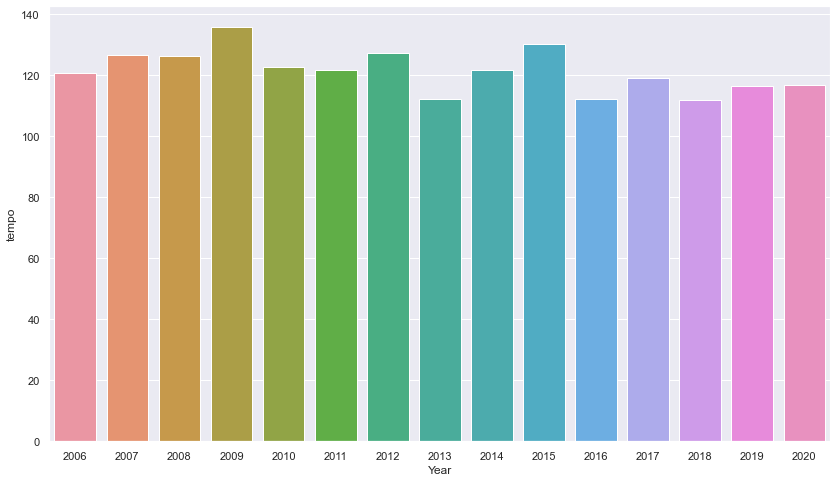

In [322]:
sns.barplot(x = df_top20_mean.index.year, y = df_top20_mean.tempo)

### Mean of top 10 tracks audio features by year

In [323]:
df_top10_mean = df_merged[df_merged.Rank.between(1,11)].groupby('Year').mean()[['Track_duration_ms', 'danceability', 'energy', 'loudness', 
                                  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                                 'tempo']]
df_top10_mean

,Track_duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Year,,,,,,,,,,
2006-01-01,226508.454545,0.726455,0.726909,-6.021364,0.082682,0.164604,0.000032,0.191573,0.677000,119.347182
2007-01-01,244421.454545,0.700727,0.640636,-6.113636,0.108573,0.200431,0.000102,0.138527,0.492182,126.181636
2008-01-01,245045.727273,0.624091,0.658182,-5.823818,0.084900,0.158255,0.000378,0.174727,0.424909,128.220091
2009-01-01,231625.181818,0.721182,0.693000,-5.872727,0.076609,0.114036,0.000171,0.206155,0.559455,127.490273
2010-01-01,235516.181818,0.709273,0.825455,-4.512182,0.078845,0.121165,0.000064,0.177555,0.579818,110.829182
2011-01-01,233217.000000,0.705400,0.789000,-5.211200,0.094990,0.145510,0.005247,0.236030,0.583600,126.336400
2012-01-01,226387.363636,0.668909,0.728545,-4.837636,0.053064,0.107736,0.000146,0.158973,0.622727,126.380545
2013-01-01,249813.363636,0.625091,0.671091,-5.451909,0.071509,0.163437,0.000204,0.211182,0.583000,122.891636
2014-01-01,212394.818182,0.668364,0.694545,-5.413364,0.079564,0.189195,0.000006,0.150627,0.640182,124.483091


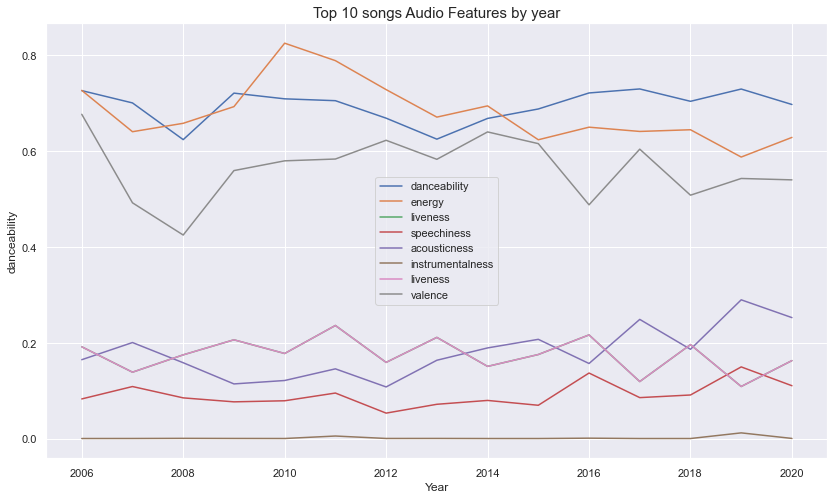

In [331]:
plt.figure(figsize = (14, 8))
plt.title("Top 10 songs Audio Features by year", fontsize = 15)
lines = ['danceability','energy','liveness','speechiness','acousticness',
         'instrumentalness','liveness','valence']
for line in lines:
    ax = sns.lineplot(x = df_top10_mean.index.year, y = line, data = df_top10_mean)
plt.legend(lines)

<AxesSubplot:xlabel='Year', ylabel='Track_duration_ms'>

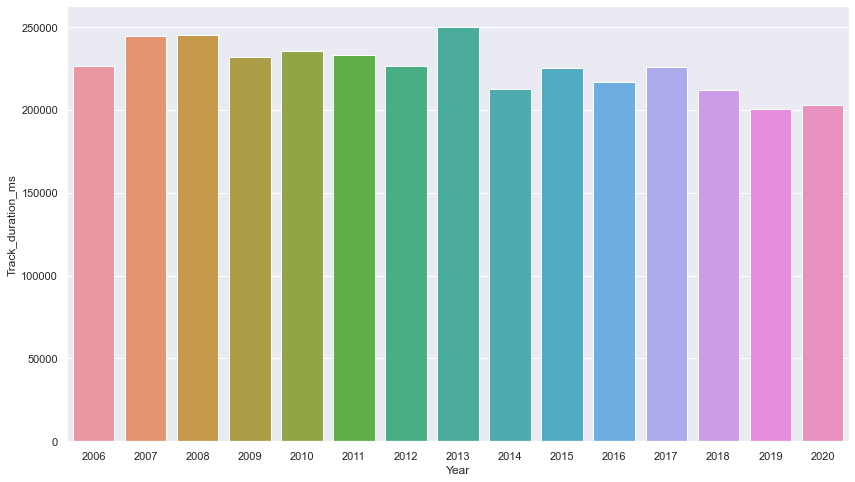

In [324]:
sns.barplot(x = df_top10_mean.index.year, y = df_top10_mean.Track_duration_ms)

<AxesSubplot:xlabel='Year', ylabel='tempo'>

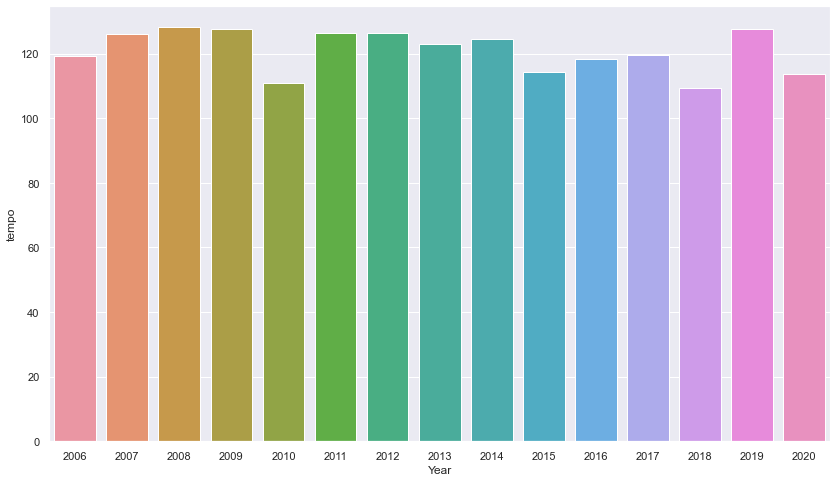

In [326]:
sns.barplot(x = df_top10_mean.index.year, y = df_top10_mean.tempo)

## Most popular artists

In [457]:
#df_merged[df_merged['Artist'].str.match(r'.*Rihanna.*') == True]

In [430]:
df_merged.groupby('Artist').count().sort_values(by = 'Rank', ascending=False).head(20).Rank

Artist
Taylor Swift           23
Rihanna                20
Drake                  18
Katy Perry             14
P!nk                   14
Maroon 5               12
Imagine Dragons        12
Adele                  11
Chris Brown            10
Bruno Mars             10
The Black Eyed Peas    10
Miley Cyrus            10
Kelly Clarkson         10
Lady Gaga              10
Britney Spears         10
Beyonce                10
Ed Sheeran             10
Ne-Yo                   9
Luke Bryan              9
The Weeknd              9
Name: Rank, dtype: int64

We have 20 artist that have appeared in the data set the most. However it deos not inlude if the artist was featuring the other artist. To extract top 10 or top 20 most artist we will have to use regext to extract all the information from the 'Artist' column.

In [429]:
top_30_artists = df_merged.groupby('Artist').count().sort_values(by = 'Rank', ascending=False).head(30).index
top_30_artists

Index(['Taylor Swift', 'Rihanna', 'Drake', 'Katy Perry', 'P!nk', 'Maroon 5',
       'Imagine Dragons', 'Adele', 'Chris Brown', 'Bruno Mars',
       'The Black Eyed Peas', 'Miley Cyrus', 'Kelly Clarkson', 'Lady Gaga',
       'Britney Spears', 'Beyonce', 'Ed Sheeran', 'Ne-Yo', 'Luke Bryan',
       'The Weeknd', 'Ariana Grande', 'Justin Timberlake', 'Jason Derulo',
       'Shawn Mendes', 'Nickelback', 'Fall Out Boy', 'Post Malone',
       'Justin Bieber', 'Sam Smith', 'OneRepublic'],
      dtype='object', name='Artist')

In [432]:
df_merged[df_merged['Artist'].str.match(r'.*Taylor Swift.*') == True]

28

In [443]:
artists_reg = []
appearances = []


for artist in top_30_artists:
    artists_reg.append(artist)
    appearances.append(len(df_merged[df_merged['Artist'].str.match(f'.*{artist}.*') == True]))

In [450]:
top_30_artists_regex = pd.DataFrame(data = [artists_reg, appearances]).T
top_30_artists_regex.columns = ['Artist', 'Appearances']

In [460]:
top_30_artists_regex = top_30_artists_regex.sort_values(by = 'Appearances', ascending = False).reset_index(drop = True)
top_30_artists_regex

,Artist,Appearances
0,Drake,56
1,Rihanna,44
2,Chris Brown,32
3,Taylor Swift,28
4,Justin Bieber,23
5,Maroon 5,21
6,Katy Perry,20
7,Justin Timberlake,20
8,Ariana Grande,20
9,Ne-Yo,18


After analysing most appearances with regex, we can see that the table look totaly different

### By artist who appeared 20 or more times

In [475]:
artists_more_than_20 = top_30_artists_regex.head(9)
artists_more_than_20

,Artist,Appearances
0,Drake,56
1,Rihanna,44
2,Chris Brown,32
3,Taylor Swift,28
4,Justin Bieber,23
5,Maroon 5,21
6,Katy Perry,20
7,Justin Timberlake,20
8,Ariana Grande,20


In [477]:
new_df = pd.DataFrame()
for artist in artists_more_than_20.Artist:
    
    new_df = new_df.append(df_merged[df_merged['Artist'].str.match(f'.*{artist}.*') == True])

In [478]:
new_df

,Rank,Title,Artist,Year,Track_id,Track_duration_ms,Track_popularity,Track_explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
321,22,Best I Ever Had,Drake,2009-01-01,3QLjDkgLh9AOEHlhQtDuhs,257690,75,True,0.395,0.922,1,-2.176,0.3750,0.1900,0.000000,0.1340,0.558,162.361,4
387,88,Forever,"Drake Featuring Kanye West, Lil Wayne & Eminem",2009-01-01,6IBcOGPsniK3Pso1wHIhew,232533,83,False,0.487,0.650,0,-5.195,0.0253,0.1910,0.000000,0.0933,0.456,151.964,4
431,32,Find Your Love,Drake,2010-01-01,4BycRneKmOs6MhYG9THsuX,208946,62,False,0.627,0.614,6,-6.006,0.1700,0.0211,0.000000,0.0286,0.758,96.038,4
459,60,Over,Drake,2010-01-01,3QyoC6OvQUmpQwQZ18iaTs,183070,76,True,0.568,0.788,5,-6.280,0.0377,0.0101,0.000000,0.1410,0.460,104.959,4
470,71,Forever,"Drake Featuring Kanye West, Lil Wayne & Eminem",2010-01-01,6IBcOGPsniK3Pso1wHIhew,232533,83,False,0.487,0.650,0,-5.195,0.0253,0.1910,0.000000,0.0933,0.456,151.964,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,36,"Break Up With Your Girlfriend, I'm Bored",Ariana Grande,2019-01-01,4kV4N9D1iKVxx1KLvtTpjS,190440,78,True,0.726,0.554,5,-5.290,0.0917,0.0421,0.000000,0.1060,0.335,169.999,4
1369,72,Breathin,Ariana Grande,2019-01-01,4OafepJy2teCjYJbvFE60J,198160,74,True,0.568,0.656,8,-5.413,0.0433,0.0211,0.000014,0.2130,0.364,100.049,4
1395,98,Boyfriend,Ariana Grande & Social House,2019-01-01,6uNuN11C1YErjR51z29SK8,173360,2,False,0.716,0.547,10,-6.059,0.0507,0.0344,0.001840,0.0931,0.362,96.977,4
1445,48,Rain On Me,Lady Gaga & Ariana Grande,2020-01-01,24ySl2hOPGCDcxBxFIqWBu,182200,81,False,0.672,0.855,9,-3.764,0.0397,0.0210,0.000000,0.3230,0.646,123.056,4


In [473]:
new_df

,Rank,Title,Artist,Year,Track_id,Track_duration_ms,Track_popularity,Track_explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature


In [468]:
artist = 'Rihanna'

In [471]:
df_merged[df_merged['Artist'].str.match(f'.*{artist}.*') == True]

,Rank,Title,Artist,Year,Track_id,Track_duration_ms,Track_popularity,Track_explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
18,19,SOS,Rihanna,2006-01-01,30cSNer6TV8x2utjULVeQ5,238920,73,False,0.677,0.671,7,-4.905,0.0361,0.00400,0.000051,0.4130,0.527,137.046,4
27,28,Unfaithful,Rihanna,2006-01-01,13xxBnXOuiBxVxJI458B0i,226973,70,False,0.588,0.391,0,-8.607,0.0334,0.83900,0.000000,0.2270,0.349,144.069,4
101,2,Umbrella,Rihanna Featuring Jay-Z,2007-01-01,49FYlytm3dAAraYgpoJZux,275986,82,False,0.583,0.829,1,-4.603,0.1340,0.00864,0.000000,0.0426,0.575,174.028,4
184,85,Break It Off,Rihanna & Sean Paul,2007-01-01,5892YX6q8y3Rs9OysF08kv,93969,76,False,0.577,0.788,11,-6.737,0.0977,0.01400,0.000003,0.1230,0.644,172.926,4
189,90,Shut Up And Drive,Rihanna,2007-01-01,4Tn2llBm1g0UlWctmgPL8Z,212280,69,False,0.735,0.826,1,-4.902,0.0349,0.00101,0.129000,0.1970,0.740,132.964,4
211,12,Take A Bow,Rihanna,2008-01-01,3goSVuTt3fDYDP6kRnFwuL,229413,75,False,0.697,0.467,9,-7.536,0.0715,0.24800,0.000000,0.0941,0.572,82.082,4
215,16,Disturbia,Rihanna,2008-01-01,2VOomzT6VavJOGBeySqaMc,238626,77,False,0.707,0.813,11,-4.515,0.0571,0.08630,0.000000,0.1680,0.722,124.921,4
216,17,Don't Stop The Music,Rihanna,2008-01-01,0ByMNEPAPpOR5H69DVrTNy,267080,78,False,0.835,0.669,6,-5.582,0.0643,0.03360,0.000069,0.0535,0.542,122.668,4
236,37,Live Your Life,T.I. Featuring Rihanna,2008-01-01,3jlbL2OTD5YmIunYzgQTAN,338853,77,True,0.375,0.862,11,-3.363,0.2550,0.07100,0.000000,0.2110,0.478,159.841,4
261,62,Hate That I Love You,Rihanna Featuring Ne-Yo,2008-01-01,7iu0WYLdo4yksKf3seaxzI,218946,69,False,0.637,0.730,5,-5.380,0.0874,0.32300,0.000000,0.0981,0.732,93.867,4


### What to extract from spotify:
- release_date
- track id
- artist id
- name (of the artist / band)
- type (artist/band)
- duration (seconds)
- genres
- popularity?
- 

## rough notebook

In [ ]:
'''
audio_features=[]
for track_id in artist_track_id:
    audio_url= 'https://api.spotify.com/v1/audio-features/'+track_id
    res=requests.get(audio_url,headers=headers)
    audio_info=res.json()
    audio_features.append(audio_info)
'''

In [ ]:
artist_name = 'Depeche Mode'
url = 'https://api.spotify.com/v1/search'

In [ ]:
artist = requests.get(url, params = {'q':artist_name, 'type':'artist', 'market':'DK'}, headers = headers)

In [ ]:
artist

In [ ]:
url = 'https://api.spotify.com/v1/artists'
requests.get(url, headers = headers, params = {'ids':'762310PdDnwsDxAQxzQkfX'}).json()

In [ ]:
# extracting main info from the songs
'''
track_name = "More Than My Hometown"
url = 'https://api.spotify.com/v1/search'

track = requests.get(url, headers = headers, params = {'q':track_name, 'type':'track'}).json()

track_name = track['tracks']['items'][0]['name']
artist_name = track['tracks']['items'][0]['album']['artists'][0]['name']
track_id = track['tracks']['items'][0]['id']
track_duration_ms = track['tracks']['items'][0]['duration_ms']
track_explicit = track['tracks']['items'][0]['explicit']
track_popularity = track['tracks']['items'][0]['popularity']
'''

In [ ]:
'''
    track_name = track['tracks']['items'][0]['name']
    artist_name = track['tracks']['items'][0]['album']['artists'][0]['name']
    track_id = track['tracks']['items'][0]['id']
    track_duration_ms = track['tracks']['items'][0]['duration_ms']
    track_explicit = track['tracks']['items'][0]['explicit']
    track_popularity = track['tracks']['items'][0]['popularity']
    '''

In [ ]:
'''

url = 'https://api.spotify.com/v1/audio-features'

danceability = [] #555
energy = [] #461
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []

for track_id in df.Track_id:
    track_request = requests.get(url, headers = headers, params = {'ids':track_id}).json()
    
    danceability.append(track_request['audio_features'][0]['danceability'])
    energy.append(track_request['audio_features'][0]['energy'])
    
'''

In [ ]:
'''
# sito nereikia
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []

for track_data in requests_list:
    
    i = 0
    
    for i in range(len(requests_list)):
        
        danceability.append(requests_list[i]['danceability'])
        energy.append(requests_list[i]['energy'])
        key.append(requests_list[i]['key'])
        loudness.append(requests_list[i]['loudness'])
        mode.append(requests_list[i]['mode'])
        speechiness.append(requests_list[i]['speechiness'])
        acousticness.append(requests_list[i]['acousticness'])
        instrumentalness.append(requests_list[i]['instrumentalness'])
        liveness.append(requests_list[i]['liveness'])
        valence.append(requests_list[i]['valence'])
        tempo.append(requests_list[i]['tempo'])
        
        i += 1
        
'''

In [175]:
# Getting album uri

url = 'https://api.spotify.com/v1/search'

track = requests.get(url, headers = headers, params = {'q':'Nothing else matters', 'type':'track'}).json()

track['tracks']['items'][0]['album']['id']

'6QdCohkHKNTVoaSx1ZzitH'

In [176]:
# Getting album data

url = 'https://api.spotify.com/v1/albums/6QdCohkHKNTVoaSx1ZzitH'

album = requests.get(url, headers = headers, params = {'ids':'6QdCohkHKNTVoaSx1ZzitH'}).json()


In [177]:
album

{'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2ye2Wgw4gimLv2eAKyk1NB'},
   'href': 'https://api.spotify.com/v1/artists/2ye2Wgw4gimLv2eAKyk1NB',
   'id': '2ye2Wgw4gimLv2eAKyk1NB',
   'name': 'Metallica',
   'type': 'artist',
   'uri': 'spotify:artist:2ye2Wgw4gimLv2eAKyk1NB'}],
 'available_markets': ['CA', 'US'],
 'copyrights': [{'text': '1991 Blackened Recordings', 'type': 'C'},
  {'text': '1991 Blackened Recordings', 'type': 'P'}],
 'external_ids': {'upc': '0093624986553'},
 'external_urls': {'spotify': 'https://open.spotify.com/album/6QdCohkHKNTVoaSx1ZzitH'},
 'genres': [],
 'href': 'https://api.spotify.com/v1/albums/6QdCohkHKNTVoaSx1ZzitH',
 'id': '6QdCohkHKNTVoaSx1ZzitH',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab67616d0000b273af07dc851962508661bbcfce',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67616d00001e02af07dc851962508661bbcfce',
   'width': 300},
  {'height': 64,
   'url

# Notes
- add spotify API key and secret to different jupyter notebook and run it form here